<center><h1 style="font-size:3em"> Gender Recognition</h1></center>

<center><h4> Using MFCC and GMM</h4></center>

In [14]:
%pip install numpy matplotlib spicy librosa python_speech_features sounddevice pydub os


ERROR: Could not find a version that satisfies the requirement os (from versions: none)
ERROR: No matching distribution found for os


In [20]:
# Data manipulation
import numpy as np
import matplotlib.pyplot as plt

# Feature extraction
import scipy
import librosa
import python_speech_features as mfcc
import os
from scipy.io.wavfile import read

# Model training
from sklearn.mixture import GaussianMixture as GMM
from sklearn import preprocessing
import pickle

# Live recording
import sounddevice as sd
import soundfile as sf

from pydub import AudioSegment

c:\Users\AGUS JUNIARTHA\Documents\tugas degung\Smart-Voice-Assistant-\.venv\Lib\site-packages\pydub\utils.py:170: RuntimeWarning: Couldn't find ffmpeg or avconv - defaulting to ffmpeg, but may not work
  warn("Couldn't find ffmpeg or avconv - defaulting to ffmpeg, but may not work", RuntimeWarning)


# Feature extraction and GMM fitting

In [1]:
def plot_audio_signal(signal, sample_rate, title="Audio Signal"):
    time = np.arange(0, len(signal)) / sample_rate
    plt.plot(time, signal)
    plt.title(title)
    plt.xlabel("Time (seconds)")
    plt.ylabel("Amplitude")
    plt.show()

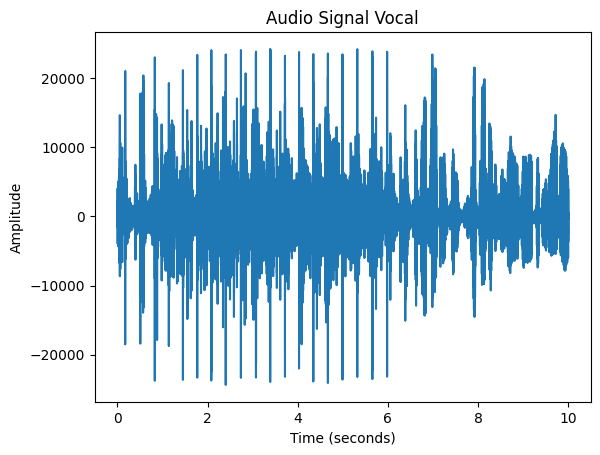

In [21]:
audio_file_path1 = "AudioSet/male_clips"


audio_path = os.path.join('AudioSet/male_clips/-0CAdy06NRo.wav')
audio = AudioSegment.from_wav(audio_path)

signal = np.array(audio.get_array_of_samples())
sample_rate = audio.frame_rate
plot_audio_signal(signal, sample_rate, title=f"Audio Signal Vocal")

In [25]:
def get_MFCC(sr,audio):
    
    features = mfcc.mfcc(audio, sr, 0.025, 0.01, 13, appendEnergy = False)
    features = preprocessing.scale(features)
    
    return features

In [26]:
def get_features(source):
    
    # Split files
    files = [os.path.join(source,f) for f in os.listdir(source) if f.endswith('.wav')]
    len_train = int(len(files)*0.8)
    train_files = files[:len_train]
    test_files = files[len_train:]
    
    # Train features
    features_train = []
    for f in train_files:
        sr, audio = read(f)
        vector = get_MFCC(sr,audio)
        if len(features_train) == 0:
            features_train = vector
        else:
            features_train = np.vstack((features_train, vector))
            
    # Test features  
    features_test = []
    for f in test_files:
        sr, audio = read(f)
        vector = get_MFCC(sr,audio)
        if len(features_test) == 0:
            features_test = vector
        else:
            features_test = np.vstack((features_test, vector))
            
    return features_train, features_test

## Male

In [27]:
source = "AudioSet/male_clips"
features_train_male, features_test_male = get_features(source)

In [28]:
gmm_male = GMM(n_components = 8, max_iter = 200, covariance_type = 'diag', n_init = 3)
gmm_male.fit(features_train_male)

GaussianMixture(covariance_type='diag', max_iter=200, n_components=8, n_init=3)

## Female

In [29]:
source = "AudioSet/female_clips"
features_train_female, features_test_female =  get_features(source)

In [30]:
gmm_female = GMM(n_components = 8, max_iter=200, covariance_type='diag', n_init = 3)
gmm_female.fit(features_train_female)

GaussianMixture(covariance_type='diag', max_iter=200, n_components=8, n_init=3)

## Visualization

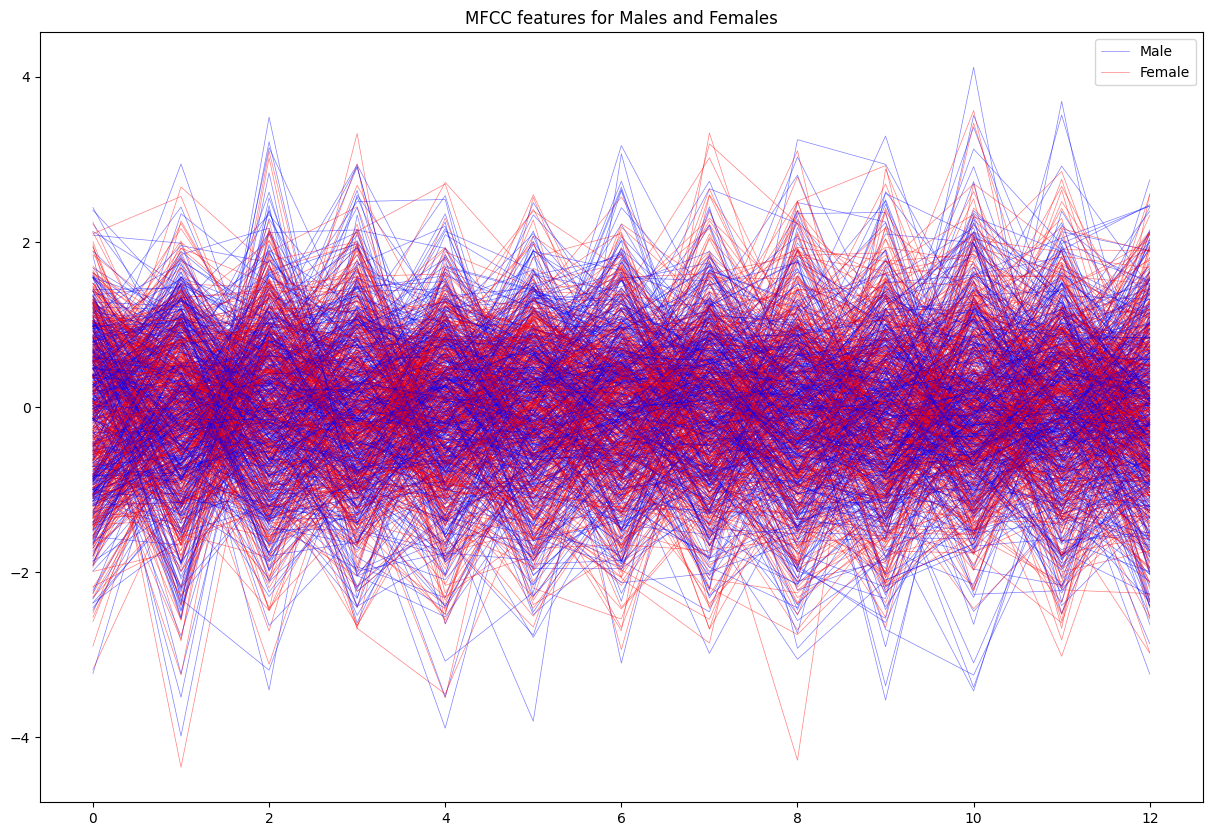

In [33]:
plt.figure(figsize=(15,10))
for i in range(1, 430000, 1000):
    plt.plot(features_train_male[i], c='b', linewidth=0.5, alpha=0.5)
    plt.plot(features_train_female[i], c='r', linewidth=0.5, alpha=0.5)
plt.plot(features_male[i+1], c='b', label="Male", linewidth=0.5, alpha=0.5)
plt.plot(features_female[i+1], c='r', label="Female", linewidth=0.5, alpha=0.5)
plt.legend()
plt.title("MFCC features for Males and Females")
plt.show()

# Accuracy in test

In [34]:
output = []

for f in features_test_male:

    log_likelihood_male = np.array(gmm_male.score([f])).sum()
    log_likelihood_female = np.array(gmm_female.score([f])).sum()
    
    if log_likelihood_male > log_likelihood_female:
        output.append(0)
    else:
        output.append(1)

In [35]:
accuracy_male = (1 - sum(output)/len(output))
accuracy_male

0.6406891715917059

In [36]:
output = []

for f in features_test_female:
    log_likelihood_male = np.array(gmm_male.score([f])).sum()
    log_likelihood_female = np.array(gmm_female.score([f])).sum()
    
    if log_likelihood_male > log_likelihood_female:
        output.append(0)
    else:
        output.append(1)

In [37]:
accuracy_female = (sum(output)/len(output))
accuracy_female

0.6347819086127312

# Retrain on the whole data

In [32]:
def get_features(source):
    
    files = [os.path.join(source,f) for f in os.listdir(source) if f.endswith('.wav')]
    
    features = []
    for f in files:
        sr,audio = read(f)
        vector   = get_MFCC(sr,audio)
        if len(features) == 0:
            features = vector
        else:
            features = np.vstack((features, vector))

    return features

source_male = "AudioSet/male_clips"
features_male = get_features(source_male)

gmm_male = GMM(n_components = 8, max_iter=200, covariance_type='diag', n_init = 3)
gmm_male.fit(features_male)

source_female = "AudioSet/female_clips"
features_female = get_features(source_female)

gmm_female = GMM(n_components = 8, max_iter=200, covariance_type='diag', n_init = 3)
gmm_female.fit(features_female)

# Save models
pickle.dump(gmm_male, open("male.gmm", "wb" ))
pickle.dump(gmm_female, open("female.gmm", "wb" ))

# Real time prediction

In [20]:
def record_and_predict(sr=16000, channels=1, duration=3, filename='pred_record.wav'):
    
    recording = sd.rec(int(duration * sr), samplerate=sr, channels=channels).reshape(-1)
    sd.wait()
    
    save_path = os.path.join(os.getcwd(), filename)
    print("Saving recording to: {}".format(save_path))
    sf.write(save_path, recording, sr)
    
    
    features = get_MFCC(sr,recording)
    scores = None

    log_likelihood_male = np.array(gmm_male.score(features)).sum()
    log_likelihood_female = np.array(gmm_female.score(features)).sum()

    if log_likelihood_male >= log_likelihood_female:
        return("Male")
    else:
        return("Female")

In [38]:
def record_and_predict(sr=16000, channels=1, duration=3, filename='AudioSet/male_clips/-0CAdy06NRo.wav'):
    
    #    open audio file and read to numpy array
    path = os.path.join(os.getcwd(), filename)
    recording = read(path)[1]
    
    features = get_MFCC(sr,recording)
    scores = None

    log_likelihood_male = np.array(gmm_male.score(features)).sum()
    log_likelihood_female = np.array(gmm_female.score(features)).sum()

    if log_likelihood_male >= log_likelihood_female:
        return("Male")
    else:
        return("Female")

In [41]:
record_and_predict()

'Male'